# Project 1: Michael Kim and Drew Mendinueto (2)

# Question 4

In [1]:
import pandas as pd
import seaborn as sn
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
import operator
import numpy as np 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
# Load the dataset
from sklearn.datasets import fetch_20newsgroups
# To create more consistency:
import numpy as np 
np.random.seed(42) 
import random 
random.seed(42)
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline

In [2]:
from string import punctuation
from sklearn.feature_extraction import text
import re
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk import pos_tag
import nltk
from sklearn.feature_extraction.text import CountVectorizer
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, 
                                   random_state = None, 
                                   remove = ('headers', 'footers'))
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, 
                                  random_state = None, 
                                  remove = ('headers', 'footers'))


analyzer = CountVectorizer().build_analyzer()
stop_words_en = stopwords.words('english')
stop_words_skt = text.ENGLISH_STOP_WORDS
combined_stopwords = set.union(set(stop_words_en),set(punctuation), set(stop_words_skt))
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords
            and not word.isdigit())

def stem_rmv_puncNoLem(docIn):
    bagWords = []
    doc = re.findall(r"[\w']+|[.,!?;]", docIn)
    for word in lemmatize_sent(doc):
        if word not in combined_stopwords and not word.isdigit():
            bagWords.append(word)
    # print(len(bagWords))
    return ' '.join(word for word in bagWords)

In [3]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

In [4]:
print(train_dataset.target)
# Change to 2 categories (0-3: Computer Technology and 4-7: Recreational Activity)
for x in range(len(train_dataset.target)):
    if (train_dataset.target[x] <= 3):
        train_dataset.target[x] = 0
    else:
         train_dataset.target[x] = 1
print(train_dataset.target)
            
print(test_dataset.target)
for x in range(len(test_dataset.target)):
    if (test_dataset.target[x] <= 3):
        test_dataset.target[x] = 0
    else:
         test_dataset.target[x] = 1
            
print(test_dataset.target)

[6 7 4 ... 6 6 2]
[1 1 1 ... 1 1 0]
[7 3 3 ... 2 6 0]
[1 0 0 ... 0 1 0]


## Hard Margin

In [5]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', LinearSVC(loss='hinge',C=1000)),
])
clf = pipeline.fit(train_dataset.data, train_dataset.target)
predict = pipeline.predict(test_dataset.data)

/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy:0.9701587301587301
precision:0.9634448574969021
recall:0.9779874213836478
f1 score:0.9706616729088638
Confusion matrix, without normalization (Hard Margin SVM)
[[1501   59]
 [  35 1555]]
Normalized confusion matrix (Hard Margin SVM)
[[0.96217949 0.03782051]
 [0.02201258 0.97798742]]


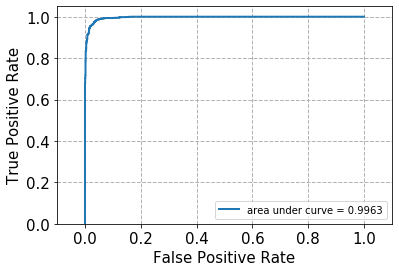

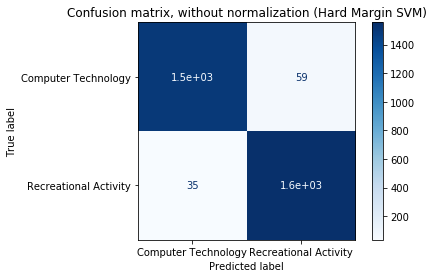

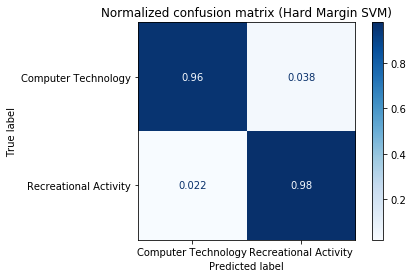

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print("accuracy:{}".format(accuracy_score(test_dataset.target, predict)))
print("precision:{}".format(precision_score(test_dataset.target, predict)))
print("recall:{}".format(recall_score(test_dataset.target, predict)))
print("f1 score:{}".format(2*precision_score(test_dataset.target, predict)*
                           recall_score(test_dataset.target, predict)/
                           (precision_score(test_dataset.target, predict)+recall_score(test_dataset.target, predict))))
if hasattr(pipeline, 'decision_function'):
    prob_score = pipeline.decision_function(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score)
else:
    prob_score = pipeline.predict_proba(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score[:,1])

plot_roc(fpr, tpr)

titles_options = [("Confusion matrix, without normalization (Hard Margin SVM)", None),
                  ("Normalized confusion matrix (Hard Margin SVM)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset.data, test_dataset.target,
                                 display_labels=["Computer Technology", "Recreational Activity"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Soft Margin

In [7]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', LinearSVC(loss='hinge',C=0.001)),
])
clf = pipeline.fit(train_dataset.data, train_dataset.target)
predict = pipeline.predict(test_dataset.data)

accuracy:0.5831746031746031
precision:0.5477092662762659
recall:1.0
f1 score:0.7077676385488537
Confusion matrix, without normalization (Soft Margin SVM)
[[ 247 1313]
 [   0 1590]]
Normalized confusion matrix (Soft Margin SVM)
[[0.15833333 0.84166667]
 [0.         1.        ]]


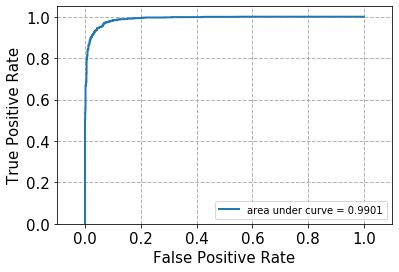

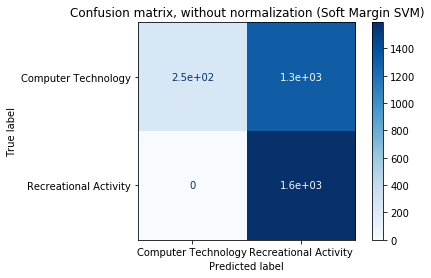

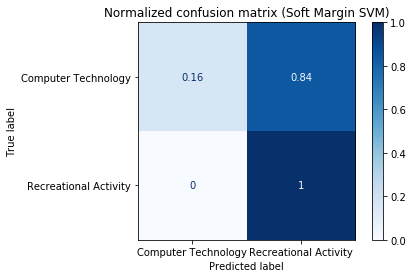

In [8]:
print("accuracy:{}".format(accuracy_score(test_dataset.target, predict)))
print("precision:{}".format(precision_score(test_dataset.target, predict)))
print("recall:{}".format(recall_score(test_dataset.target, predict)))
print("f1 score:{}".format(2*precision_score(test_dataset.target, predict)*
                           recall_score(test_dataset.target, predict)/
                           (precision_score(test_dataset.target, predict)+recall_score(test_dataset.target, predict))))
if hasattr(pipeline, 'decision_function'):
    prob_score = pipeline.decision_function(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score)
else:
    prob_score = pipeline.predict_proba(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score[:,1])

plot_roc(fpr, tpr)

titles_options = [("Confusion matrix, without normalization (Soft Margin SVM)", None),
                  ("Normalized confusion matrix (Soft Margin SVM)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset.data, test_dataset.target,
                                 display_labels=["Computer Technology", "Recreational Activity"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## C = 104.81131341546852

In [9]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', LinearSVC(loss='hinge',C=104.81131341546852)),
])
clf = pipeline.fit(train_dataset.data, train_dataset.target)
predict = pipeline.predict(test_dataset.data)

/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy:0.9717460317460317
precision:0.9652820830750155
recall:0.9792452830188679
f1 score:0.9722135497970652
Confusion matrix, without normalization (SVM C=104.8113)
[[1504   56]
 [  33 1557]]
Normalized confusion matrix (SVM C=104.8113)
[[0.96410256 0.03589744]
 [0.02075472 0.97924528]]


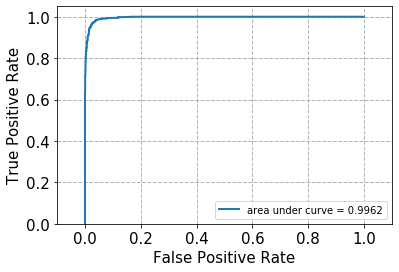

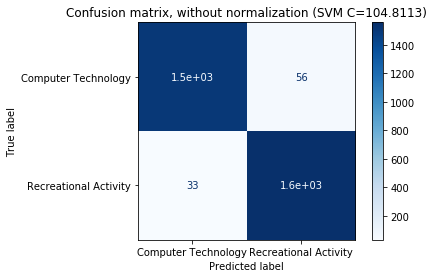

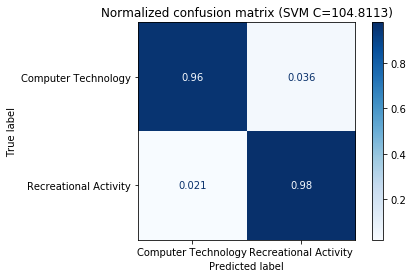

In [10]:
print("accuracy:{}".format(accuracy_score(test_dataset.target, predict)))
print("precision:{}".format(precision_score(test_dataset.target, predict)))
print("recall:{}".format(recall_score(test_dataset.target, predict)))
print("f1 score:{}".format(2*precision_score(test_dataset.target, predict)*
                           recall_score(test_dataset.target, predict)/
                           (precision_score(test_dataset.target, predict)+recall_score(test_dataset.target, predict))))
if hasattr(pipeline, 'decision_function'):
    prob_score = pipeline.decision_function(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score)
else:
    prob_score = pipeline.predict_proba(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score[:,1])

plot_roc(fpr, tpr)

titles_options = [("Confusion matrix, without normalization (SVM C=104.8113)", None),
                  ("Normalized confusion matrix (SVM C=104.8113)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset.data, test_dataset.target,
                                 display_labels=["Computer Technology", "Recreational Activity"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Question 5

In [11]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', LogisticRegression(random_state=0, C=10000)),
])
clf = pipeline.fit(train_dataset.data, train_dataset.target)
predict = pipeline.predict(test_dataset.data)

/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


accuracy:0.9726984126984127
precision:0.9670807453416149
recall:0.9792452830188679
f1 score:0.973125
Confusion matrix, without normalization (LogReg w/o Reg.)
[[1507   53]
 [  33 1557]]
Normalized confusion matrix (LogReg w/o Reg.)
[[0.96602564 0.03397436]
 [0.02075472 0.97924528]]


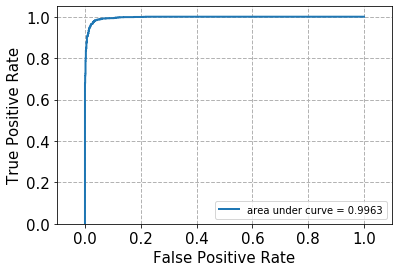

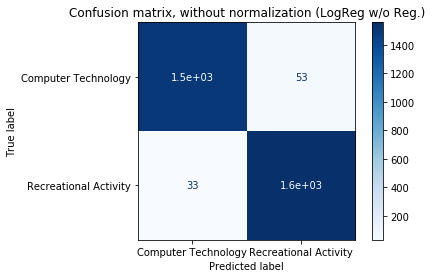

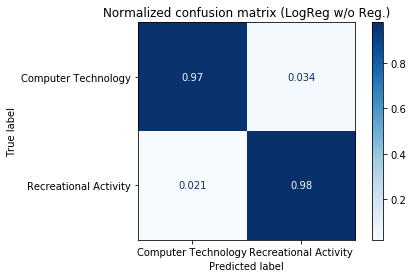

In [12]:
print("accuracy:{}".format(accuracy_score(test_dataset.target, predict)))
print("precision:{}".format(precision_score(test_dataset.target, predict)))
print("recall:{}".format(recall_score(test_dataset.target, predict)))
print("f1 score:{}".format(2*precision_score(test_dataset.target, predict)*
                           recall_score(test_dataset.target, predict)/
                           (precision_score(test_dataset.target, predict)+recall_score(test_dataset.target, predict))))
if hasattr(pipeline, 'decision_function'):
    prob_score = pipeline.decision_function(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score)
else:
    prob_score = pipeline.predict_proba(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score[:,1])

plot_roc(fpr, tpr)

titles_options = [("Confusion matrix, without normalization (LogReg w/o Reg.)", None),
                  ("Normalized confusion matrix (LogReg w/o Reg.)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset.data, test_dataset.target,
                                 display_labels=["Computer Technology", "Recreational Activity"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## L2 Regularization

In [13]:
# LogisticRegression(random_state=0, C=184.207, solver = 'liblinear', penalty = 'l2')
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', LogisticRegression(random_state=0, C=184.207, solver = 'liblinear', penalty = 'l2')),
])
clf = pipeline.fit(train_dataset.data, train_dataset.target)
predict = pipeline.predict(test_dataset.data)

accuracy:0.9723809523809523
precision:0.9659020458772474
recall:0.979874213836478
f1 score:0.9728379644083671
Confusion matrix, without normalization (L2 C=184.207)
[[1505   55]
 [  32 1558]]
Normalized confusion matrix (L2 C=184.207)
[[0.96474359 0.03525641]
 [0.02012579 0.97987421]]


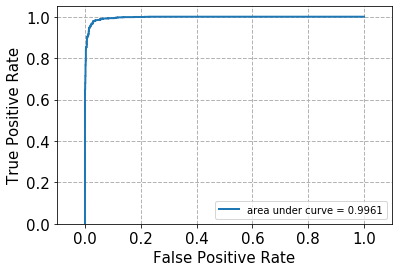

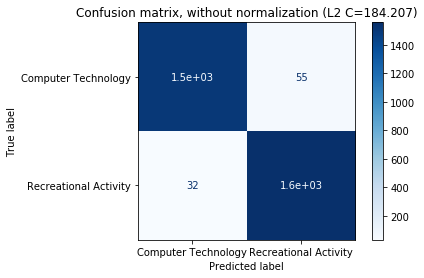

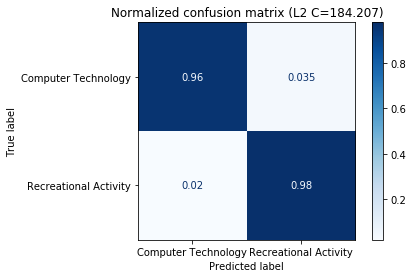

In [14]:
print("accuracy:{}".format(accuracy_score(test_dataset.target, predict)))
print("precision:{}".format(precision_score(test_dataset.target, predict)))
print("recall:{}".format(recall_score(test_dataset.target, predict)))
print("f1 score:{}".format(2*precision_score(test_dataset.target, predict)*
                           recall_score(test_dataset.target, predict)/
                           (precision_score(test_dataset.target, predict)+recall_score(test_dataset.target, predict))))
if hasattr(pipeline, 'decision_function'):
    prob_score = pipeline.decision_function(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score)
else:
    prob_score = pipeline.predict_proba(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score[:,1])

plot_roc(fpr, tpr)

titles_options = [("Confusion matrix, without normalization (L2 C=184.207)", None),
                  ("Normalized confusion matrix (L2 C=184.207)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset.data, test_dataset.target,
                                 display_labels=["Computer Technology", "Recreational Activity"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## L1 Regularization

In [15]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', LogisticRegression(random_state=0, C=323.746, solver = 'liblinear', penalty = 'l1')),
])
clf = pipeline.fit(train_dataset.data, train_dataset.target)
predict = pipeline.predict(test_dataset.data)

accuracy:0.9726984126984127
precision:0.9670807453416149
recall:0.9792452830188679
f1 score:0.973125
Confusion matrix, without normalization (L1 C=323.746)
[[1507   53]
 [  33 1557]]
Normalized confusion matrix (L1 C=323.746)
[[0.96602564 0.03397436]
 [0.02075472 0.97924528]]


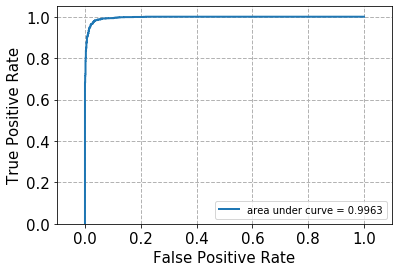

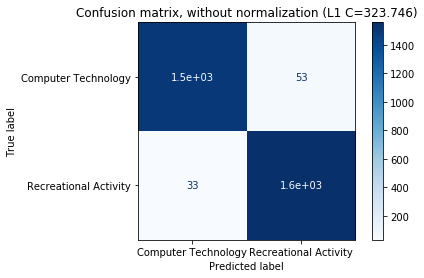

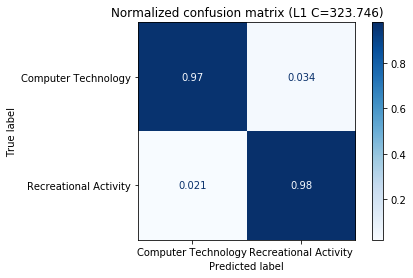

In [16]:
print("accuracy:{}".format(accuracy_score(test_dataset.target, predict)))
print("precision:{}".format(precision_score(test_dataset.target, predict)))
print("recall:{}".format(recall_score(test_dataset.target, predict)))
print("f1 score:{}".format(2*precision_score(test_dataset.target, predict)*
                           recall_score(test_dataset.target, predict)/
                           (precision_score(test_dataset.target, predict)+recall_score(test_dataset.target, predict))))
if hasattr(pipeline, 'decision_function'):
    prob_score = pipeline.decision_function(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score)
else:
    prob_score = pipeline.predict_proba(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score[:,1])

plot_roc(fpr, tpr)

titles_options = [("Confusion matrix, without normalization (L1 C=323.746)", None),
                  ("Normalized confusion matrix (L1 C=323.746)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset.data, test_dataset.target,
                                 display_labels=["Computer Technology", "Recreational Activity"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Question 6

In [17]:
# GaussianNB()
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', GaussianNB()),
])
clf = pipeline.fit(train_dataset.data, train_dataset.target)
predict = pipeline.predict(test_dataset.data)

accuracy:0.8123809523809524
precision:0.7370669197911723
recall:0.9767295597484277
f1 score:0.8401406545847986
Confusion matrix, without normalization (Gaussian)
[[1006  554]
 [  37 1553]]
Normalized confusion matrix (Gaussian)
[[0.64487179 0.35512821]
 [0.02327044 0.97672956]]


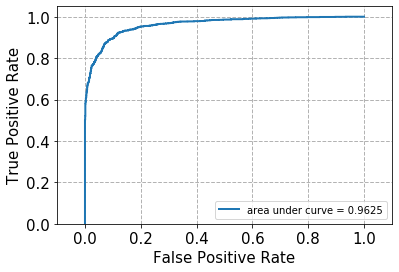

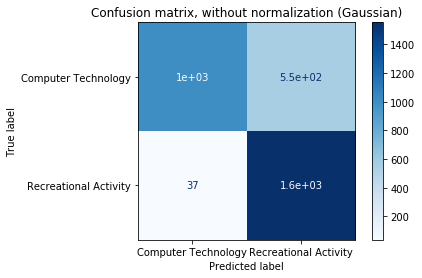

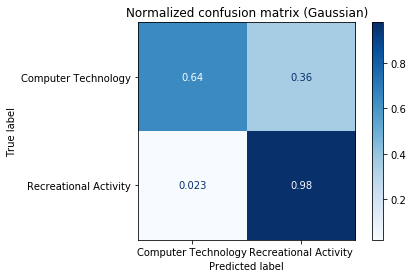

In [18]:
print("accuracy:{}".format(accuracy_score(test_dataset.target, predict)))
print("precision:{}".format(precision_score(test_dataset.target, predict)))
print("recall:{}".format(recall_score(test_dataset.target, predict)))
print("f1 score:{}".format(2*precision_score(test_dataset.target, predict)*
                           recall_score(test_dataset.target, predict)/
                           (precision_score(test_dataset.target, predict)+recall_score(test_dataset.target, predict))))
if hasattr(pipeline, 'decision_function'):
    prob_score = pipeline.decision_function(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score)
else:
    prob_score = pipeline.predict_proba(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score[:,1])

plot_roc(fpr, tpr)

titles_options = [("Confusion matrix, without normalization (Gaussian)", None),
                  ("Normalized confusion matrix (Gaussian)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset.data, test_dataset.target,
                                 display_labels=["Computer Technology", "Recreational Activity"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

# Question 8

In [19]:
categories8 = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
               'misc.forsale', 'soc.religion.christian']

train_dataset8 = fetch_20newsgroups(subset = 'train', categories = categories8, shuffle = True, 
                                   random_state = None, 
                                   remove = ('headers', 'footers'))
test_dataset8 = fetch_20newsgroups(subset = 'test', categories = categories8, shuffle = True, 
                                   random_state = None, 
                                   remove = ('headers', 'footers'))

pipeline8 = Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', GaussianNB()),
])

param_grid8 = [
    {   # One vs Rest
        'clf': [LinearSVC(loss='hinge',C=104.81131341546852)]
    },
    {   # One vs One
        'clf': [SVC()]
    },
    {   #
        'clf': [GaussianNB()]
    },
]
grid8 = GridSearchCV(pipeline8, cv=5, n_jobs=1, param_grid=param_grid8, scoring='accuracy')
grid8.fit(test_dataset8.data, test_dataset8.target)

/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the num

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer=<function stem_rmv_punc at 0x1a22cbe560>,
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=5,
                                                        ngram_range=(1, 1),
                          

In [20]:
df = pd.DataFrame(grid8.cv_results_)
pd.set_option('display.max_rows', df.shape[0]+1)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.331714,0.319823,3.534176,0.300166,"LinearSVC(C=104.81131341546852, class_weight=N...","{'clf': LinearSVC(C=104.81131341546852, class_...",0.846645,0.865815,0.859425,0.884984,0.900958,0.871565,0.019212,2
1,14.251173,0.288874,3.558155,0.282282,"SVC(C=1.0, break_ties=False, cache_size=200, c...","{'clf': SVC(C=1.0, break_ties=False, cache_siz...",0.884984,0.862620,0.862620,0.884984,0.916933,0.882428,0.019942,1
2,14.158657,0.321043,3.542054,0.298019,"GaussianNB(priors=None, var_smoothing=1e-09)","{'clf': GaussianNB(priors=None, var_smoothing=...",0.753994,0.734824,0.702875,0.677316,0.776358,0.729073,0.035370,3


In [21]:
pipelineSVC = Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', SVC(probability=True)),
])

clf = pipelineSVC.fit(train_dataset8.data, train_dataset8.target)
predictSVC = pipelineSVC.predict(test_dataset8.data)

In [22]:
print("accuracy:{}".format(accuracy_score(test_dataset8.target, predictSVC)))
print("precision:{}".format(precision_score(test_dataset8.target, predictSVC, average = 'micro')))
print("recall:{}".format(recall_score(test_dataset8.target, predictSVC, average = 'micro')))
print("f1 score:{}".format(2*precision_score(test_dataset8.target, predictSVC, average = 'micro')*
                           recall_score(test_dataset8.target, predictSVC, average = 'micro')/
                           (precision_score(test_dataset8.target, predictSVC, average = 'micro')+
                            recall_score(test_dataset8.target, predictSVC, average = 'micro'))))

accuracy:0.860702875399361
precision:0.860702875399361
recall:0.860702875399361
f1 score:0.860702875399361


Multi-class w/o normalization (SVC)
[[334  42  16   0]
 [ 72 296  15   2]
 [ 33  19 336   2]
 [  4   1  12 381]]
Normalized multi-class confusion matrix (SVC)
[[0.85204082 0.10714286 0.04081633 0.        ]
 [0.18701299 0.76883117 0.03896104 0.00519481]
 [0.08461538 0.04871795 0.86153846 0.00512821]
 [0.01005025 0.00251256 0.03015075 0.95728643]]


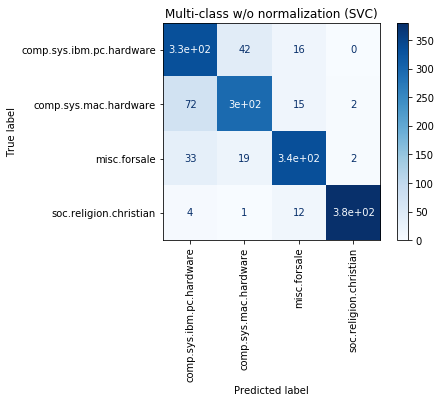

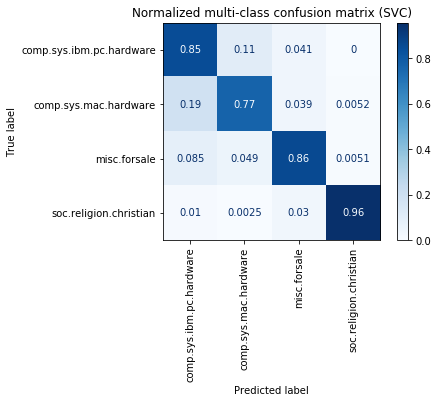

In [26]:
titles_options = [("Multi-class w/o normalization (SVC)", None),
                  ("Normalized multi-class confusion matrix (SVC)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset8.data, test_dataset8.target,
                                 display_labels=categories8,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.xticks(rotation=90)
plt.show()

In [34]:
pipelineSVC = Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', GaussianNB()),
])

clf = pipelineSVC.fit(train_dataset8.data, train_dataset8.target)
predictSVC = pipelineSVC.predict(test_dataset8.data)

accuracy:0.6824281150159744
precision:0.6824281150159744
recall:0.6824281150159744
f1 score:0.6824281150159744
Multi-class w/o normalization (Gaussian)
[[239  37  93  23]
 [ 95 159  87  44]
 [ 54  22 277  37]
 [  0   0   5 393]]
Normalized multi-class confusion matrix (Gaussian)
[[0.60969388 0.09438776 0.2372449  0.05867347]
 [0.24675325 0.41298701 0.22597403 0.11428571]
 [0.13846154 0.05641026 0.71025641 0.09487179]
 [0.         0.         0.01256281 0.98743719]]


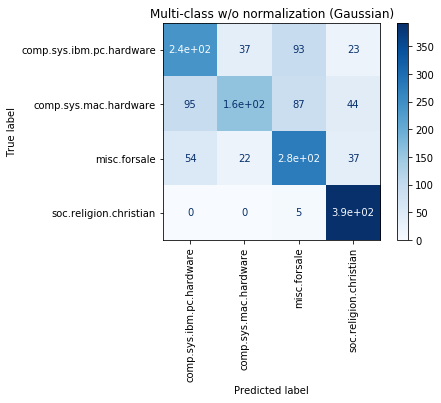

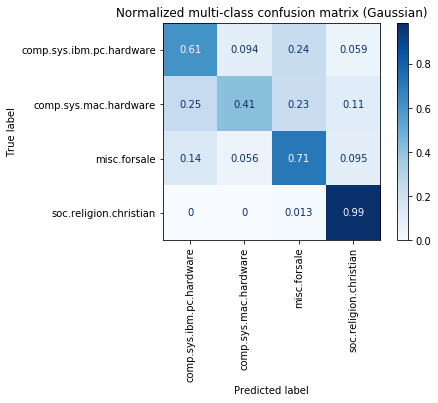

In [35]:
print("accuracy:{}".format(accuracy_score(test_dataset8.target, predictSVC)))
print("precision:{}".format(precision_score(test_dataset8.target, predictSVC, average = 'micro')))
print("recall:{}".format(recall_score(test_dataset8.target, predictSVC, average = 'micro')))
print("f1 score:{}".format(2*precision_score(test_dataset8.target, predictSVC, average = 'micro')*
                           recall_score(test_dataset8.target, predictSVC, average = 'micro')/
                           (precision_score(test_dataset8.target, predictSVC, average = 'micro')+
                            recall_score(test_dataset8.target, predictSVC, average = 'micro'))))
titles_options = [("Multi-class w/o normalization (Gaussian)", None),
                  ("Normalized multi-class confusion matrix (Gaussian)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset8.data, test_dataset8.target,
                                 display_labels=categories8,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.xticks(rotation=90)
plt.show()

In [36]:
pipelineSVC = Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', LinearSVC(loss='hinge',C=104.81131341546852)),
])

clf = pipelineSVC.fit(train_dataset8.data, train_dataset8.target)
predictSVC = pipelineSVC.predict(test_dataset8.data)

/Users/MichaelK./.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy:0.8492012779552716
precision:0.8492012779552716
recall:0.8492012779552716
f1 score:0.8492012779552716
Multi-class w/o normalization (LinearSVC)
[[310  55  25   2]
 [ 69 296  18   2]
 [ 27  23 337   3]
 [  5   1   6 386]]
Normalized multi-class confusion matrix (LinearSVC)
[[0.79081633 0.14030612 0.06377551 0.00510204]
 [0.17922078 0.76883117 0.04675325 0.00519481]
 [0.06923077 0.05897436 0.86410256 0.00769231]
 [0.01256281 0.00251256 0.01507538 0.96984925]]


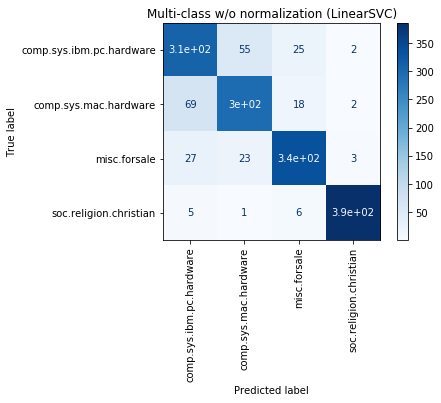

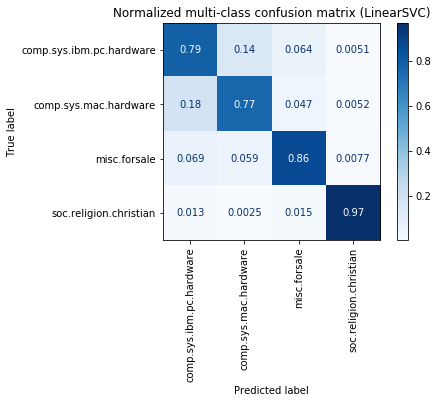

In [37]:
print("accuracy:{}".format(accuracy_score(test_dataset8.target, predictSVC)))
print("precision:{}".format(precision_score(test_dataset8.target, predictSVC, average = 'micro')))
print("recall:{}".format(recall_score(test_dataset8.target, predictSVC, average = 'micro')))
print("f1 score:{}".format(2*precision_score(test_dataset8.target, predictSVC, average = 'micro')*
                           recall_score(test_dataset8.target, predictSVC, average = 'micro')/
                           (precision_score(test_dataset8.target, predictSVC, average = 'micro')+
                            recall_score(test_dataset8.target, predictSVC, average = 'micro'))))
titles_options = [("Multi-class w/o normalization (LinearSVC)", None),
                  ("Normalized multi-class confusion matrix (LinearSVC)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset8.data, test_dataset8.target,
                                 display_labels=categories8,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    plt.xticks(rotation=90)
plt.show()

## Question 7

In [38]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5, stop_words=combined_stopwords, analyzer = stem_rmv_punc)),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=0)),
    ('clf', LogisticRegression(random_state=0, C=323.746, solver = 'liblinear', penalty = 'l1')),
])
clf = pipeline.fit(train_dataset.data, train_dataset.target)
predict = pipeline.predict(test_dataset.data)

accuracy:0.9733333333333334
precision:0.9677018633540373
recall:0.979874213836478
f1 score:0.97375
Confusion matrix, without normalization (L1, W/O headers/footers, min_df = 5, Lemmatized, LSI/LSA)
[[1508   52]
 [  32 1558]]
Normalized confusion matrix (L1, W/O headers/footers, min_df = 5, Lemmatized, LSI/LSA)
[[0.96666667 0.03333333]
 [0.02012579 0.97987421]]


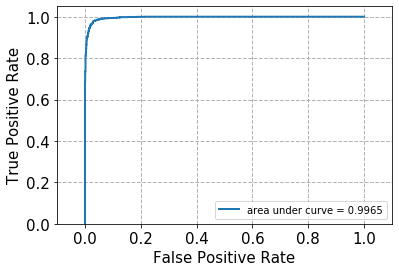

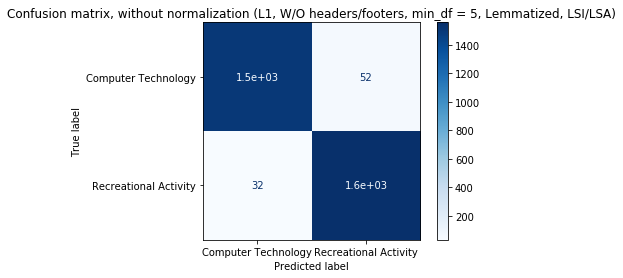

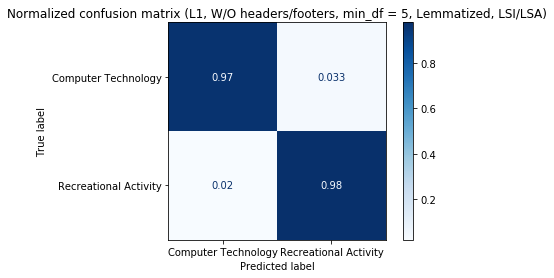

In [39]:
print("accuracy:{}".format(accuracy_score(test_dataset.target, predict)))
print("precision:{}".format(precision_score(test_dataset.target, predict)))
print("recall:{}".format(recall_score(test_dataset.target, predict)))
print("f1 score:{}".format(2*precision_score(test_dataset.target, predict)*
                           recall_score(test_dataset.target, predict)/
                           (precision_score(test_dataset.target, predict)+recall_score(test_dataset.target, predict))))
if hasattr(pipeline, 'decision_function'):
    prob_score = pipeline.decision_function(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score)
else:
    prob_score = pipeline.predict_proba(test_dataset.data)
    fpr, tpr, _ = roc_curve(test_dataset.target, prob_score[:,1])

plot_roc(fpr, tpr)

titles_options = [("Confusion matrix, without normalization (L1, W/O headers/footers, min_df = 5, Lemmatized, LSI/LSA)", None),
                  ("Normalized confusion matrix (L1, W/O headers/footers, min_df = 5, Lemmatized, LSI/LSA)", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, test_dataset.data, test_dataset.target,
                                 display_labels=["Computer Technology", "Recreational Activity"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()